# 라이브러리

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, hog
from skimage.measure import shannon_entropy
import matplotlib.pyplot as plt
from tqdm import tqdm

# 데이터

## 데이터 경로

In [2]:
#베이스 경로는 자신의 것으로 바꿔주세요
base_path='/content/drive/MyDrive/공모전/CSIRO - Image2Biomass Prediction/csiro-biomass'
train_csv_path = os.path.join(base_path, "train.csv")
train_img_dir = os.path.join(base_path, "train")

In [3]:
for dirname, _, filenames in os.walk(base_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/공모전/CSIRO - Image2Biomass Prediction/csiro-biomass/test.csv
/content/drive/MyDrive/공모전/CSIRO - Image2Biomass Prediction/csiro-biomass/train.csv
/content/drive/MyDrive/공모전/CSIRO - Image2Biomass Prediction/csiro-biomass/sample_submission.csv
/content/drive/MyDrive/공모전/CSIRO - Image2Biomass Prediction/csiro-biomass/train/ID1011485656.jpg
/content/drive/MyDrive/공모전/CSIRO - Image2Biomass Prediction/csiro-biomass/train/ID1012260530.jpg
/content/drive/MyDrive/공모전/CSIRO - Image2Biomass Prediction/csiro-biomass/train/ID1025234388.jpg
/content/drive/MyDrive/공모전/CSIRO - Image2Biomass Prediction/csiro-biomass/train/ID1051144034.jpg
/content/drive/MyDrive/공모전/CSIRO - Image2Biomass Prediction/csiro-biomass/train/ID1028611175.jpg
/content/drive/MyDrive/공모전/CSIRO - Image2Biomass Prediction/csiro-biomass/train/ID1036339023.jpg
/content/drive/MyDrive/공모전/CSIRO - Image2Biomass Prediction/csiro-biomass/train/ID1035947949.jpg
/content

## 데이터 로드

### csv

In [4]:
data = pd.read_csv(train_csv_path)
data.head()

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750


In [5]:
data["image_id"]=data["image_path"].str[6:]
image_info = data[["Sampling_Date", "State", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm", "image_id"]].copy().drop_duplicates().reset_index(drop=True)
images_target = data.pivot(index="image_id", columns="target_name", values="target").reset_index()
image_info = image_info.merge(images_target, on="image_id")
image_info = image_info[['image_id', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm',
                         'Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']]
image_info.drop(columns=["Sampling_Date", "State"], inplace=True)
image_info.head()

,image_id,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,ID1011485656.jpg,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750
1,ID1012260530.jpg,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000
2,ID1025234388.jpg,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500
3,ID1028611175.jpg,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376
4,ID1035947949.jpg,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605


### image

In [6]:
# 전체 이미지 경로 컬럼 생성
image_info['full_path'] = image_info['image_id'].apply(lambda x: os.path.join(train_img_dir, x))

총 이미지 개수: 357
--------------------------------------------------
이미지 ID: ID1011485656.jpg
  - 크기(Shape): (1000, 2000, 3)
  - 높이(H): 1000, 너비(W): 2000
  - 채널(C): 3


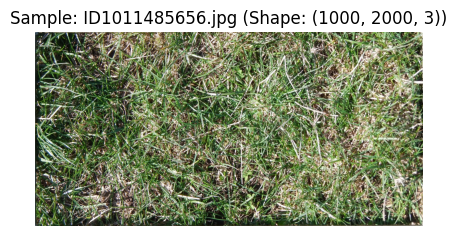

이미지 ID: ID1012260530.jpg
  - 크기(Shape): (1000, 2000, 3)
  - 높이(H): 1000, 너비(W): 2000
  - 채널(C): 3
이미지 ID: ID1025234388.jpg
  - 크기(Shape): (1000, 2000, 3)
  - 높이(H): 1000, 너비(W): 2000
  - 채널(C): 3
이미지 ID: ID1028611175.jpg
  - 크기(Shape): (1000, 2000, 3)
  - 높이(H): 1000, 너비(W): 2000
  - 채널(C): 3
이미지 ID: ID1035947949.jpg
  - 크기(Shape): (1000, 2000, 3)
  - 높이(H): 1000, 너비(W): 2000
  - 채널(C): 3
--------------------------------------------------


In [7]:
# 이미지 기본 정보 확인 (크기, 채널)
print(f"총 이미지 개수: {len(image_info)}")
print("-" * 50)

# 처음 5개 이미지만 샘플로 확인
sample_images = image_info.head(5)

for idx, row in sample_images.iterrows():
    path = row['full_path']
    img = cv2.imread(path)

    if img is None:
        print(f"[Error] 이미지를 찾을 수 없습니다: {path}")
        continue

    # OpenCV는 BGR로 읽으므로 RGB로 변환 (시각화를 위해)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # shape 출력: (Height, Width, Channel)
    print(f"이미지 ID: {row['image_id']}")
    print(f"  - 크기(Shape): {img.shape}")
    print(f"  - 높이(H): {img.shape[0]}, 너비(W): {img.shape[1]}")
    print(f"  - 채널(C): {img.shape[2]}") # 3이면 RGB, 4면 RGBA

    # 이미지 시각화 (첫 번째만)
    if idx == 0:
        plt.figure(figsize=(5, 5))
        plt.imshow(img_rgb)
        plt.title(f"Sample: {row['image_id']} (Shape: {img.shape})")
        plt.axis('off')
        plt.show()

print("-" * 50)

2000x1000 RGB 이미지이다

# 분석 목표

1. `Pre_GSHH_NDVI`와 `Height_Ave_cm`이 `target`과 상관이 크게 있는 것으로 확인되었다.
2. 따라서 target을 예측하기 위해 이 둘 변수를 이미지로부터 예측하여야 한다. (최대한 높은 정확도로)
3. 그러므로 이곳에선 이미지의 특성을 파악하고 어떻게 예측할 수 있을지 살펴본다.

다시 생각해보면, 굳이 해당 변수를 정확히 예측할려하지 않아도 된다고 생각한다.  
이미지에서 추출한 특성이 두 변수와 상관이 있다고 나오면, 이것을 target예측 모델에 바로 넣어도 되지 않을까? 오히려 두 변수를 예측하는 과정에서 정확도가 크게 떨어질 수 있을 것 같다.

# I. 이미지 로드 및 2가지 전처리

## A. Img_Raw (원본 RGB): 이미지 전체 로드

## B. Img_Norm (정규화 RGB): 조명(밝기)을 제거한 순수 색상 분석용 ($r, g, b$).
$$r = R/\Sigma, g = G/\Sigma, b = B/\Sigma$$

## C. Img_Tex (CLAHE Grayscale): 질감 및 형태 분석용.Grayscale 변환 $\rightarrow$ CLAHE 적용 (대비 극대화).

## 결과확인

# II. 마스크 생성 (Color & Segmentation)

목표: 흙(Soil), 죽은 풀(Dead), 산 풀(Green), 그림자(Shadow) 영역 분리

## A. 초록 식물 마스크 (Mask_Green)
- Source: Img_Norm
- Action: $ExG = 2g - r - b$ 계산.
- Threshold: $ExG > 0$ (또는 Otsu 알고리즘 자동 임계값)인 픽셀.
- 용도: $GDM\_g$ (녹색 총량) 예측, Texture 분석 시 ROI(관심 영역) 설정.

## B. 고사 식물 마스크 (Mask_Dead)
- Source: Img_Raw $\rightarrow$ HSV 변환
- Action: $H$(Hue) 채널에서 노란색~갈색 범위 ($20^\circ \sim 50^\circ$) 필터링.
- 용도: $Dry\_Dead\_g$ 예측.Tip: 만약 HSV가 잘 안 먹히면, Img_Norm에서 $ExR = 1.4r - g$ 사용.

## C. 그림자 마스크 (Mask_Shadow)
- Source: Img_Raw $\rightarrow$ HSV 변환
- Action: $V$(Value) 채널에서 하위 10~20% 어두운 픽셀 필터링.
- 용도: $Height$, $Biomass$ (부피감) 예측.

# III. 특징 추출 (Feature Extraction)

위에서 만든 이미지와 마스크를 조합하여 수치형 변수를 뽑아냅니다.

## A. 면적(Quantity) 계산
- Green_Pixel_Count: Mask_Green의 픽셀 수 합계.$\rightarrow$ Target: $GDM\_g$ (강력한 상관관계 예상)
- Dead_Pixel_Count: Mask_Dead의 픽셀 수 합계.$\rightarrow$ Target: $Dry\_Dead\_g$ (우선 고사 실물의 색상이 어떤지 직접 이미지를 보고 판단해야함)
- Shadow_Green_Ratio: Mask_Green 대비 Mask_Shadow가 차지하는 비율.$\rightarrow$ Target: $Height$, $Dry\_Total\_g$ (키가 크면 그림자가 많음)

## B. 식생 지수 (Quality) - NDVI 예측용
- Avg_Greenness: Mask_Green 영역 내부의 Img_Norm $g$값 평균.
- Avg_ExG: Mask_Green 영역 내부의 $ExG$ 값 평균.
- $\rightarrow$ Target: $Pre\_GSHH\_NDVI$ (더 진한 초록색일수록 높음)

# 지금까지 내용을 한번에 전처리

## 전처리 함수

III-B까지 한번에 전처리하는 함수를 생성한다.  
나머지는 III-C는 미리 해야할 것이 많기 때문에 따로 진행한다.



나중에 이것들이 정해지고 나면 그때는 한번에 `get_features_from_path`함수에 추가한다.

또한 이미지 자체는 따로 추출하여야 한다.  
렘을 많이 차지하기에 이미지 특징 추출과 따로 진행하였다.  
최종 예측에서는 이미지 자체를 분석할 필요가 없기 때문인다.

In [40]:
def get_features_from_path(path, image_id):
    """
    이미지 경로 하나를 받아서, 로드 -> 전처리 -> 특징 추출 후
    딕셔너리(Row) 형태로 반환하는 함수
    """
    # I. 이미지 로드 및 2가지 전처리
    # I-A. Img_Raw 이미지 로드
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        return None
    img_raw = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # I-B. Img_Norm (정규화 RGB)
    img_float = img_raw.astype(np.float32)
    sum_rgb = np.sum(img_float, axis=2, keepdims=True)
    img_norm = img_float / (sum_rgb + 1.0)

    # I-C. Img_Tex (CLAHE Grayscale)
    gray = cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_tex = clahe.apply(gray) # CLAHE 적용

    # II. 마스크 생성
    # II-A. Mask_Green (ExG)
    r, g, b = cv2.split(img_norm)
    exg = 2*g - r - b

    # 어느정도까지를 green마스크로 지정할것인지는 직접 확인해봐야함
    _, mask_green = cv2.threshold(exg, 0, 255, cv2.THRESH_BINARY)
    mask_green = mask_green.astype(np.uint8)

    # II-B. Mask_Dead (HSV 갈색 범위)
    ### 예시는 노랑 ~ 갈색이지만 실제 이미지를 보고 색생을 스포이드로 찍어본 후 판단해주세요
    hsv = cv2.cvtColor(img_raw, cv2.COLOR_RGB2HSV)
    mask_dead = cv2.inRange(hsv, (15, 30, 30), (35, 255, 255)) #H: 15~35, S와 V: 적당히

    # II-C. Mask_Shadow (밝기 하위 20%)
    mask_shadow = cv2.inRange(hsv, (0, 0, 0), (180, 255, 40)) # V < 40

    # III. 특징 추출
    features = {'image_id': image_id}

    # III-A. 면적 계산
    plant_area = cv2.countNonZero(mask_green)
    features['Green_Pixel_Count'] = plant_area
    features['Dead_Pixel_Count'] = cv2.countNonZero(mask_dead)
    ### 그림자 비율
    area_green = cv2.countNonZero(mask_green)
    area_shadow = cv2.countNonZero(mask_shadow)
    if area_green > 0:
        # 초록색 잎 1픽셀당 그림자가 몇 픽셀이나 생겼는가? #흙에 의한 그림자는 그냥 넘어간다
        features['Shadow_Green_Ratio'] = area_shadow / area_green
    else:
        features['Shadow_Green_Ratio'] = 0
    features['Shadow_Pixel_Count'] = area_shadow #그림자의 절대적인 양도 추가

    # III-B. 식생 지수 - NDVI

    if plant_area > 0:
        features['Avg_Greenness'] = cv2.mean(g, mask=mask_green)[0]
        features['Avg_ExG'] = cv2.mean(exg, mask=mask_green)[0]
    else:
        features['Avg_Greenness'] = 0
        features['Avg_ExG'] = 0

    return features

In [19]:
final_data = []
image_paths = image_info['full_path'].values
image_ids = image_info['image_id'].values

In [20]:
for path, img_id in tqdm(zip(image_paths, image_ids), total=len(image_paths)):
    try:
        # 하나 처리하고 결과만 받기 (이미지는 메모리에 안 남음)
        row_data = get_features_from_path(path, img_id)

        if row_data is not None:
            final_data.append(row_data)

    except Exception as e:
        print(f"Error processing {img_id}: {e}")

# 데이터프레임 변환
image_features = pd.DataFrame(final_data)
print("\n분석 완료!")
print(image_features.head())

100%|██████████| 357/357 [01:35<00:00,  3.74it/s]


분석 완료!
           image_id  Green_Pixel_Count  Dead_Pixel_Count  Shadow_Green_Ratio  \
0  ID1011485656.jpg            1818172            586734            0.112949   
1  ID1012260530.jpg             973970            369968            0.452069   
2  ID1025234388.jpg            1127904            246418            0.270286   
3  ID1028611175.jpg            1939264            555942            0.060576   
4  ID1035947949.jpg            1968021           1414487            0.061309   

   Shadow_Pixel_Count  Avg_Greenness   Avg_ExG  Texture_Contrast  \
0              205361       0.413615  0.246557       1830.424632   
1              440302       0.380131  0.145856       1523.458334   
2              304857       0.383265  0.155432       1733.049881   
3              117473       0.451829  0.361015       1595.496711   
4              120657       0.413059  0.244302       2282.779428   

   Texture_Energy  
0        0.007294  
1        0.008382  
2        0.007204  
3        0.007943  
4 

이미지 자체는 따로 추출하여야 한다.  
렘을 많이 차지하기에 이미지 특징 추출과 따로 진행하였다.  
최종 예측에서는 이미지 자체를 분석할 필요가 없기 때문인다.

## 이미지 세가지 버전 시각화

따라서 특정한 이미지 하나를 선택하여 그것을 시각화하는 함수를 생성한다.

In [32]:
def get_images_for_viz(path):
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        print(f"Error: 이미지를 찾을 수 없습니다 -> {path}")
        return None, None, None
    img_raw = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 정규화
    img_float = img_raw.astype(np.float32)
    sum_rgb = np.sum(img_float, axis=2, keepdims=True)
    img_norm = img_float / (sum_rgb + 1.0)

    # 텍스처 (CLAHE)
    gray = cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_tex = clahe.apply(gray)

    return img_raw, img_norm, img_tex

In [36]:
# 이미지 한장에 대해 세가지 버전으로 출력 시각화
def image_plot(idx):
    # 1. 이미지 한 장 로드
    img_raw, img_norm, img_tex = get_images_for_viz(image_paths[idx])

    # 2. 그림 그리기 준비
    fig = plt.figure(figsize=(15, 5))

    # (1) 원본
    plt.subplot(1, 3, 1)
    plt.imshow(img_raw)
    plt.axis('off')

    # (2) 정규화
    plt.subplot(1, 3, 2)
    plt.imshow(img_norm)
    plt.axis('off')

    # (3) 텍스처
    plt.subplot(1, 3, 3)
    plt.imshow(img_tex, cmap='gray')
    plt.axis('off')

    plt.show()

    # 3. 메모리 해제
    plt.close(fig) # 필수: 이거 안 하면 램 터짐

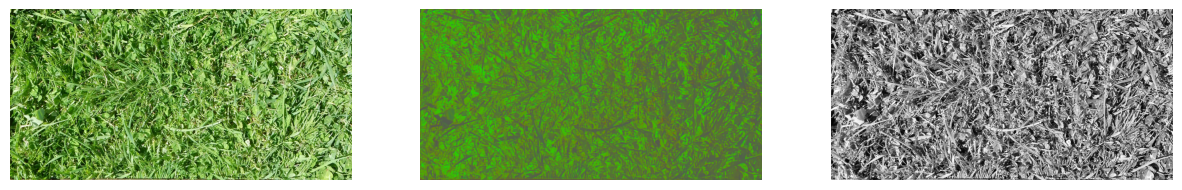

In [41]:
#이미지 출력
image_plot(5) #인덱스를 넣기

## green, dead, shadow mask 시각화

이것도 마찬가지로 선택한 인덱스의 이미지의 green, dead, shadow 마스크를 시각화하여 파라미터를 조절한다.

In [76]:
def image_masks_plot(idx):
    # 1. 이미지 한장 로드
    img_raw, img_norm, img_tex = get_images_for_viz(image_paths[idx])

    # II. 마스크 생성
    # II-A. Mask_Green (ExG)
    r, g, b = cv2.split(img_norm)
    exg = 2*g - r - b

    # 어느정도까지를 green마스크로 지정할것인지는 직접 확인해봐야함
    _, mask_green = cv2.threshold(exg, 0.05, 255, cv2.THRESH_BINARY)
    mask_green = mask_green.astype(np.uint8)


    # II-B. Mask_Dead (HSV 갈색 범위)
    ### 예시는 노랑 ~ 갈색이지만 실제 이미지를 보고 색생을 스포이드로 찍어본 후 판단해주세요
    hsv = cv2.cvtColor(img_raw, cv2.COLOR_RGB2HSV)
    mask_dead = cv2.inRange(hsv, (15, 30, 30), (35, 255, 255)) #H: 15~35, S와 V: 적당히

    # II-C. Mask_Shadow (밝기 하위 20%)
    mask_shadow_raw = cv2.inRange(hsv, (0, 0, 0), (180, 255, 40)) # V < 40
    ## 식물 영역 부풀리기 (Dilation)
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)) #부풀림 정도
    mask_green_dilated = cv2.dilate(mask_green, dilation_kernel, iterations=1)
    ## 교집합 구하기 (전체 그림자 AND 부풀린 식물 영역)
    ## 결과: 흙 그림자는 빠지고, 식물 근처 그림자만 남음
    mask_shadow = cv2.bitwise_and(mask_shadow_raw, mask_green_dilated)

#########################
    # 2. 그림 그리기 준비
    fig = plt.figure(figsize=(20, 5))

    # (0) 원본 (비교를 위해 추가하면 좋습니다)
    plt.subplot(1, 4, 1)
    plt.imshow(img_raw)
    plt.title(f"Original (idx: {idx})")
    plt.axis('off')

    # (1) Green Mask
    plt.subplot(1, 4, 2)
    plt.imshow(mask_green, cmap='gray')
    plt.title("Mask Green (ExG > 0)")
    plt.axis('off')


    # (2) Shadow Mask
    plt.subplot(1, 4, 3)
    plt.imshow(mask_shadow, cmap='gray')
    plt.title("Mask Shadow (V < 40)")
    plt.axis('off')


    # (3) Dead Mask
    plt.subplot(1, 4, 4)
    plt.imshow(mask_dead, cmap='gray')
    plt.title("Mask Dead (Brown)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 3. 메모리 해제
    plt.close(fig) # 필수: 이거 안 하면 램 터짐

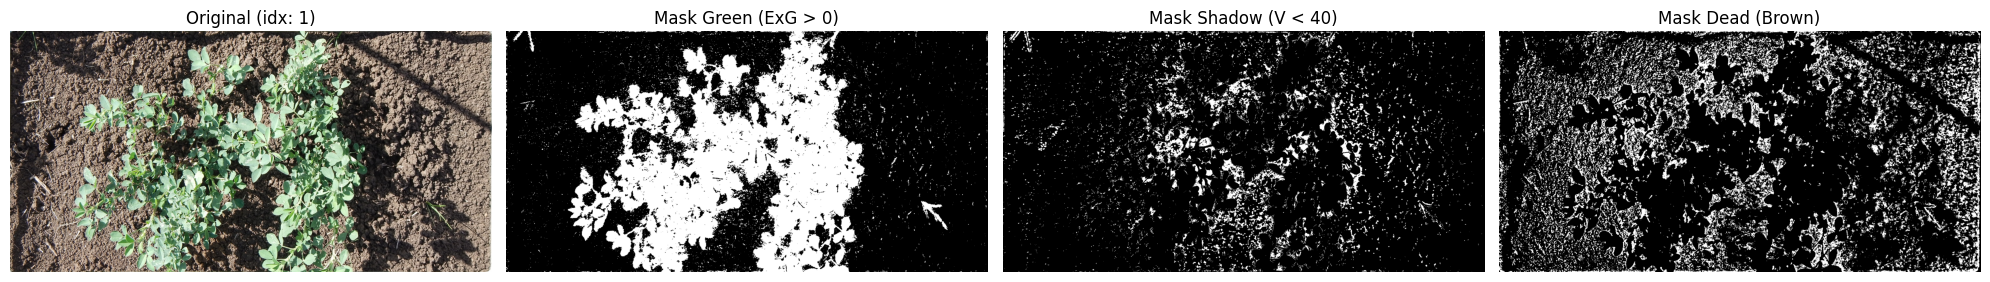

In [77]:
image_masks_plot(1)

## 긴급! green 마스크

기존의 ExG로는 풀에 햇빛이 들거나 그림자가 졌을 경우 마스킹이 제대로 안되는 문제가 있다.  
(특히 1번 인덱스의 이미지가 해당 문제점을 가지고있다.)  

문제 확인 : ExP의 임계값에 따라 쉽게 바뀐다.

따라서 HSV 또는 Lab으로 접근해야하는게 더 정확할 수 있다.

In [78]:
def compare_green_masks(idx):
    # 1. 이미지 로드
    path = image_paths[idx]
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # -----------------------------------------------------------
    # Method A: 기존 RGB (ExG)
    # -----------------------------------------------------------
    img_float = img_rgb.astype(np.float32)
    sum_rgb = np.sum(img_float, axis=2, keepdims=True) + 1.0
    img_norm = img_float / sum_rgb
    r, g, b = cv2.split(img_norm)
    exg = 2*g - r - b
    _, mask_exg = cv2.threshold(exg, 0.05, 255, cv2.THRESH_BINARY) # 임계값 조절 가능

    # -----------------------------------------------------------
    # Method B: HSV (Hue 기반)
    # -----------------------------------------------------------
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    # 초록색 범위 (H: 35~85)
    # S: 25 이상 (너무 하얀 빛 반사 제외)
    # V: 25 이상 (너무 어두운 그림자 제외)
    lower_green = np.array([35, 25, 25])
    upper_green = np.array([85, 255, 255])
    mask_hsv = cv2.inRange(hsv, lower_green, upper_green)

    # -----------------------------------------------------------
    # Method C: Lab (a channel 기반) - ★ 추천 ★
    # -----------------------------------------------------------
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l, a, b_channel = cv2.split(lab)

    # OpenCV에서 Lab의 a채널 범위는 0~255입니다. (원래 -128~127)
    # 128이 0(무채색)입니다.
    # 128보다 작으면 초록색(Green), 크면 빨간색/갈색(Red/Magenta)

    # a < 120 정도면 확실한 초록색
    # b > 130 정도면 노란끼(Yellow)가 섞인 초록색 (풀은 보통 노란끼가 섞임)

    # 조건: (a < 125) AND (b > 130) -> 이게 가장 강력한 조합 중 하나
    mask_lab = cv2.inRange(lab, (0, 0, 130), (255, 125, 255))

    # -----------------------------------------------------------
    # 시각화
    # -----------------------------------------------------------
    fig = plt.figure(figsize=(20, 5))

    # (1) 원본
    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title(f"Original (idx: {idx})")
    plt.axis('off')

    # (2) RGB (ExG)
    plt.subplot(1, 4, 2)
    plt.imshow(mask_exg, cmap='gray')
    plt.title("1. RGB (ExG)\nSensitive to Light")
    plt.axis('off')

    # (3) HSV
    plt.subplot(1, 4, 3)
    plt.imshow(mask_hsv, cmap='gray')
    plt.title("2. HSV\n(Hue 35~85)")
    plt.axis('off')

    # (4) Lab
    plt.subplot(1, 4, 4)
    plt.imshow(mask_lab, cmap='gray')
    plt.title("3. Lab\n(a < 125 & b > 130)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close(fig)

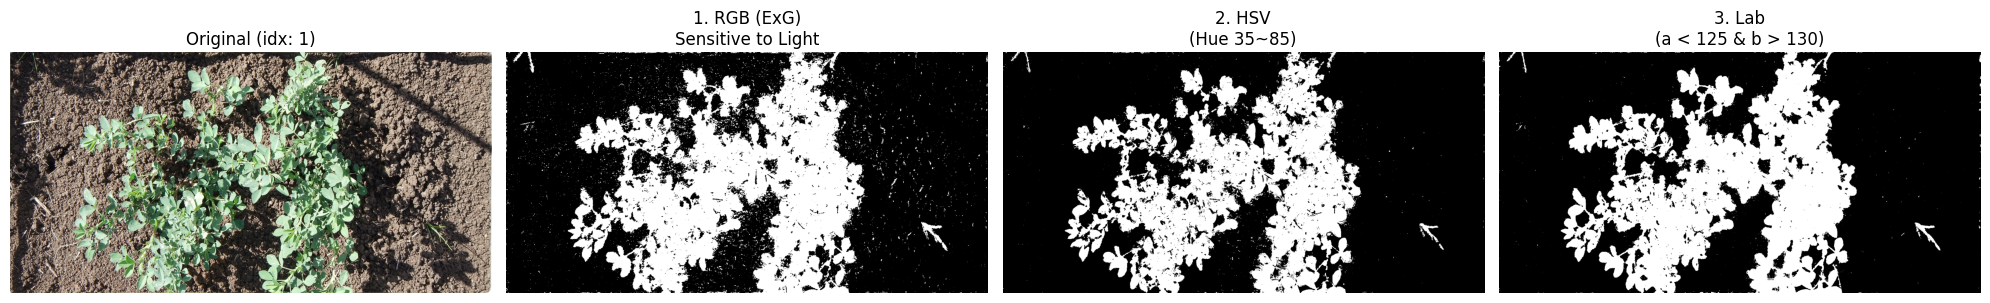

In [62]:
compare_green_masks(1)

# III. 특징 추출 (Feature Extraction) 이어서 진행

## C. 형태 및 질감 (Morphology) - Species & Height 예측용
Source: Img_Tex (CLAHE 적용됨) + Mask_Green (배경 제외용)

### i. Roughness (거칠기)
- Action: GLCM(Gray-Level Co-occurrence Matrix) 계산 $\rightarrow$ Contrast, Energy.
- $\rightarrow$ Target: $Height\_Ave\_cm$ (키가 클수록 거칠고 복잡함)

In [ ]:
glcm = graycomatrix(img_tex, distances=[1], angles=[0, np.pi/2], levels=256, symmetric=True, normed=True)
features['Texture_Contrast'] = graycoprops(glcm, 'contrast').mean()
features['Texture_Energy'] = graycoprops(glcm, 'energy').mean()

### ii. Clover Score (둥근 정도)
- Action 1 (Opening): Mask_Green에 큰 원형 커널로 Morphological Opening 적용 $\rightarrow$ 살아남은 면적 비율 계산. (풀은 사라지고 클로버만 남음)
- Action 2 (Blob): Blob Detection으로 검출된 원형 객체 수.
- $\rightarrow$ Target: $Dry\_Clover\_g$x

Morphological_Opening_Ratio (열림 연산 후 남은 면적 비율)

In [ ]:
# 1. Action 1: Morphological Opening (클로버 면적 비율)
# 둥근 커널을 사용하여 얇은 풀을 지워버림
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
opened_mask = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)

plant_area = cv2.countNonZero(mask_green) # 전체 식물 면적
clover_area = cv2.countNonZero(opened_mask) # 풀 지우고 남은 면적

# 0으로 나누기 방지
if plant_area == 0:
    clover_area_ratio = 0
else:
    clover_area_ratio = clover_area / plant_area

In [ ]:
# 2. Action 2: Blob Detection (클로버 덩어리 개수)
# img_tex: CLAHE가 적용된 Grayscale 이미지 (Step 2에서 생성한 Img_Tex)

def get_blob_count(img_gray):
    # 1. Blob Detector 파라미터 설정
    params = cv2.SimpleBlobDetector_Params()

    # (1) Threshold (임계값) 설정
    # 이미지가 어두운 곳~밝은 곳 다양하므로 범위를 넓게 잡습니다.
    params.minThreshold = 10
    params.maxThreshold = 220

    # (2) Area (면적) 필터
    # 너무 작은 점(노이즈)이나 화면을 꽉 채우는 건 무시
    params.filterByArea = True
    params.minArea = 50      # 픽셀 단위 (이미지 해상도에 따라 조절 필요)
    params.maxArea = 5000

    # (3) Circularity (원형도) 필터 - 가장 중요! ★
    # 1에 가까울수록 완벽한 원. 풀은 길쭉해서 이 값이 낮음.
    params.filterByCircularity = True
    params.minCircularity = 0.3  # 클로버 잎은 불규칙한 원형이므로 0.3~0.5 정도

    # (4) Convexity (볼록도) 필터
    # 잎은 대체로 볼록함
    params.filterByConvexity = True
    params.minConvexity = 0.2

    # (5) Inertia (관성) 필터
    # 길쭉한지 둥근지 판단. 0에 가까우면 직선, 1에 가까우면 원.
    params.filterByInertia = True
    params.minInertiaRatio = 0.1 # 풀(직선)을 거르기 위한 최소한의 장치

    # 2. Detector 생성 및 감지
    detector = cv2.SimpleBlobDetector_create(params)

    # 키포인트(감지된 Blob들) 추출
    # 입력: CLAHE 적용된 Grayscale 이미지 (img_tex)
    keypoints = detector.detect(img_gray)

    # 3. 결과 반환 (감지된 Blob의 개수)
    return len(keypoints)

num_blobs = get_blob_count(img_tex)

### iii. Grass Score (선형 정도)
- Action 1 (Edges): Canny Edge Detection $\rightarrow$ Hough Line Transform $\rightarrow$ 검출된 직선의 총 길이.
- Action 2 (HOG): HOG 특징 추출 $\rightarrow$ 특정 방향(수직/수평)의 히스토그램 강도 합계.
- $\rightarrow$ Target: $Dry\_Green\_g$

HOG_Edge_Strength (직선 에지 강도)

In [ ]:
# 1. Canny Edge Detection (에지 검출)
def get_grass_line_length(img_gray):
    # img_gray: CLAHE가 적용된 Grayscale 이미지 (img_tex)
    # 50, 150: 임계값 (상황에 따라 조절 가능하지만 50~150이 무난함)
    edges = cv2.Canny(img_gray, 50, 150)

    # 2. Hough Lines P (확률적 허프 변환) - 직선 찾기
    # minLineLength: 이 길이보다 짧은 선은 무시 (잡음 제거, 풀잎처럼 긴 것만 찾음)
    # maxLineGap: 선이 중간에 살짝 끊겨도 이 픽셀 이하면 같은 선으로 간주
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50,
                            minLineLength=30, maxLineGap=10)

    total_length = 0

    # 3. 검출된 직선들의 길이 합산
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # 유클리드 거리 공식 (직선 길이)
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            total_length += length

    return total_length

In [ ]:
line_length_sum = get_grass_line_length(img_tex)

In [ ]:
# 2. Grass Score (HOG)
# HOG 특징 추출
f, _ = hog(img_tex, orientations=8, pixels_per_cell=(16, 16),
           cells_per_block=(1, 1), visualize=True)
# 풀이 많으면 특정 방향의 Gradient가 매우 셈 -> Max값 혹은 분산 사용
hog_strength = np.mean(f) # 또는 np.max(f)

# IV. 최종 가설 검증 (Validation with Train Labels)

추출한 변수들이 실제 타겟과 얼마나 잘 맞는지 산점도(Scatter Plot)와 상관계수(Correlation Matrix)로 확인합니다.

## A. Green_Pixel_Count vs GDM_g: 선형 비례 관계인가?

## B. Dead_Pixel_Count vs Dry_Dead_g: 양의 상관관계인가?

## C. Roughness + Green_Shadow_Ratio vs Height_Ave_cm: 상관관계가 있는가?

## D. Species 구분 검증:
- Train Set의 Species 컬럼을 활용.

- Pure Clover 이미지들의 Clover Score가 높게 나오는지?

- Pure Grass 이미지들의 Grass Score가 높게 나오는지?